# Project: Customer classification (Online Retail II)

- Date: August 5 2025 - August 13 2025

- Data: This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

- Description: In this project our goal will be to use this data to detect some similarities between the customers,divide them in some groups with some particular habits or behaviors. This project could be very interresting for marketing strategies. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Download the excel file
df = pd.read_excel('/home/christian/ProjetsPerso/IA/MachineLearning/Customer_Classification/data/online_retail_II.xlsx',
                    sheet_name="Year 2010-2011",
                   dtype={"Invoice": str, "StockCode": str, "Customer ID": str},
                   parse_dates=["InvoiceDate"]
                   )

# Information on the data frame
print("Number of customers: ", df["Customer ID"].nunique())
print("Name of columns: ", df.columns)
print("Number of features(colomns):", len(df.columns))
print("shape of the data frame: ", df.shape)


Number of customers:  4372
Name of columns:  Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Number of features(colomns): 8
shape of the data frame:  (541910, 8)


## Cleaning the data
Now we will try to clean the data, deleting lines without customers or resigned transactions and to remove duplicate values. We will also add a column "Totalprice" as the multiplication of the quantity by the unity prices.

In [2]:
# delete line without Customer id
df = df.dropna(subset=["Customer ID"])
print("After drop nan Customer ID :", df.shape)

# delete not finish transaction and negative quantity
mask_return = df["Quantity"] < 0
mask_cancel = df["Invoice"].str.startswith("C")
df = df[~(mask_return | mask_cancel)]
print("After deleting unfinished transaction/neg. quantity :" , df.shape)

# delete duplicate line
df = df.drop_duplicates()
print("After drop_duplicates :", df.shape)

# columns "TotalPrice"
df["TotalPrice"]=df["Quantity"] * df["Price"]
print("After adding 'TotalPrice': ",df.shape)

After drop nan Customer ID : (406830, 8)
After deleting unfinished transaction/neg. quantity : (397925, 8)
After drop_duplicates : (392733, 8)
After adding 'TotalPrice':  (392733, 9)


In [3]:
print("Data frame: \n", df.head(20))

Data frame: 
    Invoice StockCode                          Description  Quantity  \
0   536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1   536365     71053                  WHITE METAL LANTERN         6   
2   536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3   536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4   536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5   536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6   536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7   536366     22633               HAND WARMER UNION JACK         6   
8   536366     22632            HAND WARMER RED POLKA DOT         6   
9   536368     22960             JAM MAKING SET WITH JARS         6   
10  536368     22913          RED COAT RACK PARIS FASHION         3   
11  536368     22912       YELLOW COAT RACK PARIS FASHION         3   
12  536368     22914         BLUE COAT RACK PARIS FASHION      

#### Some goals for this project:
churn risk,RFM (Recency-Frequency-Monetary), tenure, panier moyen, determinate also the product that was the most sell in term of quantity and after in term of money bring to the campany. 

## Behavioral Variables (RFM)

This variables define the behavior of a purchase of a customer. There are:

- R(Recency): numbers of days since the last command. More this value is low, more the customer is recent and potentially engaged the customer is.
- F(Frequency): total number of purchases the customer did in the period. This help to measure the faithfulness of the customer.
- M(Monetay): total amount spent by the customer in this period. show the financial value of thar client for the company.

Let's start.

In [4]:
# Date from which we will compute the number of days since the last command
date_limit=max(df["InvoiceDate"]) + pd.Timedelta(days=1)
date_limit=pd.Timestamp(date_limit).day_of_year # the number of the day in the year

print("Date limit: ",date_limit)

#Building recency
recency= (
    df.groupby("Customer ID")["InvoiceDate"] # we group by customer and toke only their invoicedate
    .max() #we select their greatest invoicedate, that means their last incode dat
    .apply( lambda last_date: (date_limit-pd.Timestamp(last_date).day_of_year)) # we compute the difference
    .reset_index() # to mage it a dataframe with two columns instead of one
    .rename(columns={"InvoiceDate":"Recency"}) # change the name of the column into Recency
)

# Display
print("Recency data frame:\n",recency)



Date limit:  344
Recency data frame:
      Customer ID  Recency
0          12346      326
1          12347        3
2          12348       76
3          12349       19
4          12350      311
...          ...      ...
4334       18280      278
4335       18281      181
4336       18282        8
4337       18283        4
4338       18287       43

[4339 rows x 2 columns]


Let's say that if a customer did not return since 100 days, we could consider him like . Personaly I don't see what is the importance of ML method like K mean method here. 

In [5]:
frequency=( 
    df.groupby("Customer ID")["Invoice"]
    .count() #we count the number of invoice each customer have
    .reset_index()
    .rename(columns={"Invoice":"Frequency"})
)

print("Frequency data frame:\n",frequency)

Frequency data frame:
      Customer ID  Frequency
0          12346          1
1          12347        182
2          12348         31
3          12349         73
4          12350         17
...          ...        ...
4334       18280         10
4335       18281          7
4336       18282         12
4337       18283        721
4338       18287         70

[4339 rows x 2 columns]


In [6]:
monetary=(
    df.groupby("Customer ID")["TotalPrice"]
    .sum() # we make the sum of each totalprice for each customer
    .reset_index()
    .rename(columns={"TotalPrice":"Monetary"})
)

print("Monetary data frame:\n",monetary)

Monetary data frame:
      Customer ID  Monetary
0          12346  77183.60
1          12347   4310.00
2          12348   1797.24
3          12349   1757.55
4          12350    334.40
...          ...       ...
4334       18280    180.60
4335       18281     80.82
4336       18282    178.05
4337       18283   2045.53
4338       18287   1837.28

[4339 rows x 2 columns]


In [7]:
#we're going to concatenate all this data frame into one n the RFM data frame.
rfm=recency.merge(frequency,on="Customer ID")\
        .merge(monetary, on="Customer ID")

print("RFM data frame:\n",rfm)

RFM data frame:
      Customer ID  Recency  Frequency  Monetary
0          12346      326          1  77183.60
1          12347        3        182   4310.00
2          12348       76         31   1797.24
3          12349       19         73   1757.55
4          12350      311         17    334.40
...          ...      ...        ...       ...
4334       18280      278         10    180.60
4335       18281      181          7     80.82
4336       18282        8         12    178.05
4337       18283        4        721   2045.53
4338       18287       43         70   1837.28

[4339 rows x 4 columns]


### Scoring
Now we will try to make the different groups using a scoring method.

Let's choose 5 groups and say that:
- for Recency: 1:the oldest customers(with older purchase dates) , 5: the regular people or the new ones
- for Frequency: 1: the customer with lower number of purchase, 5: our regular customers
- for Monetary: 1: customers who spent less money , 5: customer who spent much money

In [8]:
rfm["R_score"]=pd.qcut(rfm["Recency"],5,[5,4,3,2,1])
rfm["F_score"]=pd.qcut(rfm["Frequency"],5,[1,2,3,4,5])
rfm["M_score"]=pd.qcut(rfm["Monetary"],5,[1,2,3,4,5])

print(rfm)

     Customer ID  Recency  Frequency  Monetary R_score F_score M_score
0          12346      326          1  77183.60       1       1       5
1          12347        3        182   4310.00       5       5       5
2          12348       76         31   1797.24       2       3       4
3          12349       19         73   1757.55       4       4       4
4          12350      311         17    334.40       1       2       2
...          ...      ...        ...       ...     ...     ...     ...
4334       18280      278         10    180.60       1       1       1
4335       18281      181          7     80.82       1       1       1
4336       18282        8         12    178.05       5       1       1
4337       18283        4        721   2045.53       5       5       4
4338       18287       43         70   1837.28       3       4       4

[4339 rows x 7 columns]


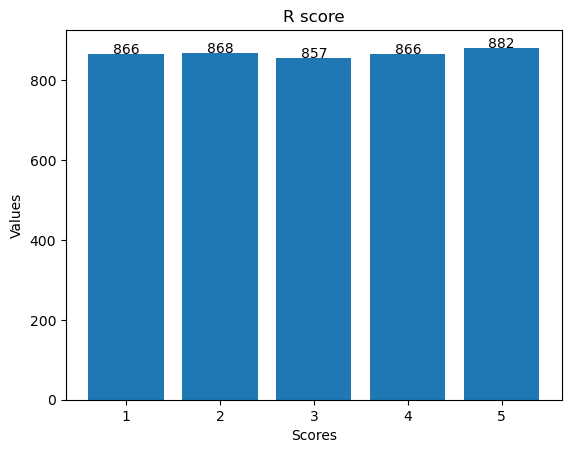

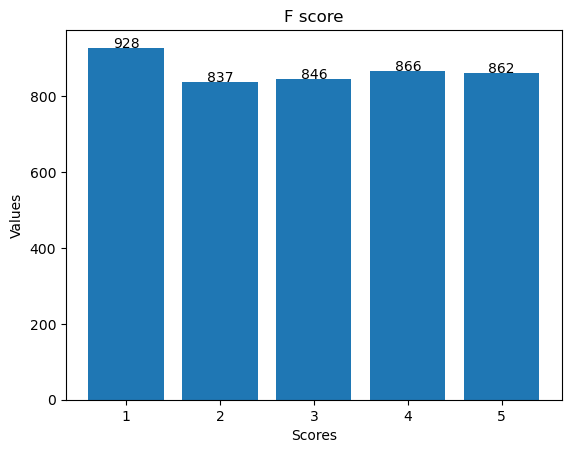

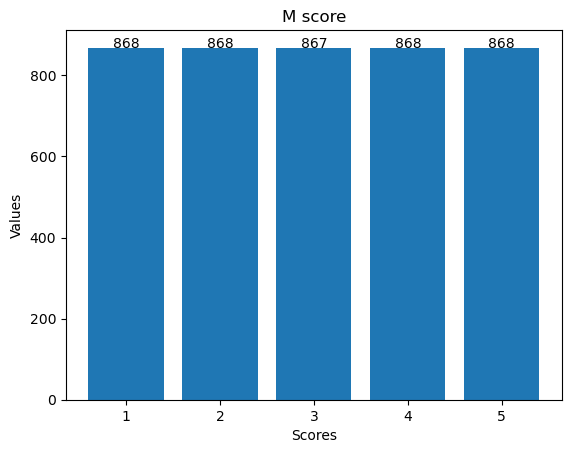

In [9]:
import numpy as np
categories=list(range(1,6))
x=np.arange(1,6)

#sizes
sizesR=[len(rfm[rfm["R_score"]==1]),len(rfm[rfm["R_score"]==2]),len(rfm[rfm["R_score"]==3]),len(rfm[rfm["R_score"]==4]),len(rfm[rfm["R_score"]==5])]
sizesF=[len(rfm[rfm["F_score"]==1]),len(rfm[rfm["F_score"]==2]),len(rfm[rfm["F_score"]==3]),len(rfm[rfm["F_score"]==4]),len(rfm[rfm["F_score"]==5])]
sizesM=[len(rfm[rfm["M_score"]==1]),len(rfm[rfm["M_score"]==2]),len(rfm[rfm["M_score"]==3]),len(rfm[rfm["M_score"]==4]),len(rfm[rfm["M_score"]==5])]

#plot
plt.figure()

#recency

plt.bar(x,sizesR)
plt.xticks(categories)
plt.xlabel("Scores");plt.ylabel("Values");plt.title("R score")
for i, v in enumerate(sizesR):
    plt.text(i+1, v + 1, str(v), ha='center')  # affiche la valeur au-dessus de chaque barre
plt.show()

#frequency

plt.bar(x,sizesF)
plt.xticks(categories)
plt.xlabel("Scores");plt.ylabel("Values");plt.title("F score")
for i, v in enumerate(sizesF):
    plt.text(i+1, v + 1, str(v), ha='center')  # affiche la valeur au-dessus de chaque barre
plt.show()

#recency

plt.bar(x,sizesM)
plt.xticks(categories)
plt.xlabel("Scores");plt.ylabel("Values");plt.title("M score")
for i, v in enumerate(sizesM):
    plt.text(i+1, v + 1, str(v), ha='center')  # affiche la valeur au-dessus de chaque barre
plt.show()



Next, let's define 3 greats classes for our customers: the VIPs, the regular ones and the  non-actif customers.
We can define wore than this 3 classes but for this project we will choose something simple like this.


How could we classify our customers regarding their scores?
- VIP: R>=3 , F>=4 , M>=4.
- Regular customers: 2<=R<=3 , 2<=F<=3 , 2<=M<=3 .
- Inactif customers: R<=2 , F<=2 , M<=2.

This distribution could be change. I just made it like that, we my own logic.

talk also about the different marketing technics that we could applu to thos different classes.

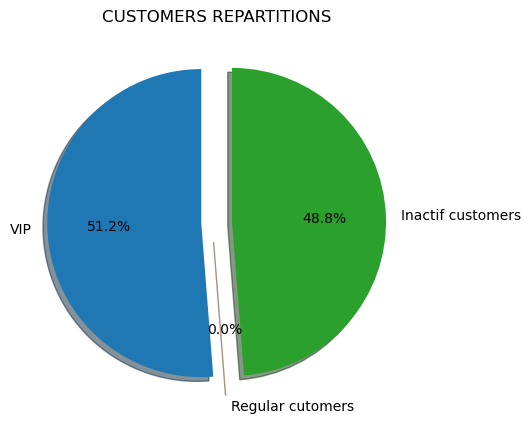

In [10]:
#construction of figures

#labels
labels=["VIP", "Regular cutomers", "Inactif customers"]
#differents percentage
sizes=[]
sizes.append(len(rfm[(rfm["R_score"]>=4) & (rfm["F_score"]>=4) & (rfm["M_score"]>=4) ])) #VIP
sizes.append(len(rfm[ (rfm["R_score"].between(2,3)) & (rfm["F_score"].between(2,3)) & (rfm["M_score"].between(2,3)) ])) #Regular customers
sizes.append(len(rfm[(rfm["R_score"]<=2) & (rfm["F_score"]<=2) & (rfm["M_score"]<=2) ])) #Inactif customers

#display
explode=(0.1,0.1,0.1) #aims to put a separation between the different parts of the circle
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True)
plt.title("CUSTOMERS REPARTITIONS")
plt.show()

#### Analysis
We can notice that the main part of the costumers of the company is the VIP , followed by the inactif customers. This is very astonishing because generally the VIP represent the fewest part (in term of persons) in a company. We also  notice that there no regular customers. Our way to distribuate the different classes has obviouly an impact on that graph. Maybe a change on that distribution would change our graphn however we will still have a great rate of VIPs for that compagny which is very crazy. 

#### Marketing analysis 

It is very important to notice that we could use the different scores made to elaborate differents marketing strategies to improve the incomes of the company. For instance, we could see the customers with the lowest recency score and create some promotions for them to encourage them to came back or do the same thing for the best customers as a gift; we could also make more publicity for customer with high frequency score (because they buy much) to push them to buy even more,....

## ML Models

Now we will  build a machine learning model to find some correlation or some group amoung this customers.

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RFM scaled:
      Customer ID  Recency_norm  Frequency_norm  Monetary_norm
0          12346      2.601852       -0.493827      56.516213
1          12347     -0.388889        1.740741       2.689672
2          12348      0.287037       -0.123457       0.833676
3          12349     -0.240741        0.395062       0.804359
4          12350      2.462963       -0.296296      -0.246820
...          ...           ...             ...            ...
4334       18280      2.157407       -0.382716      -0.360421
4335       18281      1.259259       -0.419753      -0.434122
4336       18282     -0.342593       -0.358025      -0.362305
4337       18283     -0.379630        8.395062       1.017070
4338       18287     -0.018519        0.358025       0.863250

[4339 rows x 4 columns]


Text(0.5, 1.0, 'Silhouette')

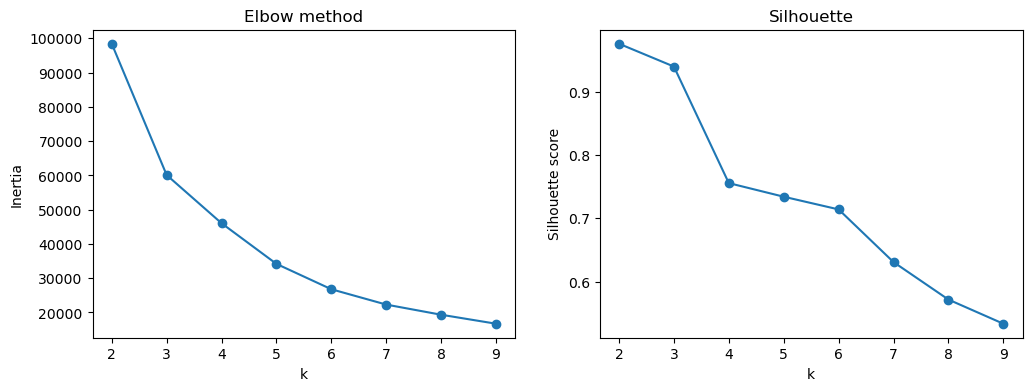

In [12]:
#Normalization of the data: to give to each column the same weight during the learning step
scaler=RobustScaler() # we use robustscaler and not stantard because the second one is sensitive to outliers and use it for Kmeans could be very bad
rfm_scaled=scaler.fit_transform(rfm[["Recency","Frequency","Monetary"]]) # we scale only this three columns
rfm_scaled=pd.DataFrame(rfm_scaled, columns=["Recency_norm", "Frequency_norm","Monetary_norm"]) #we add column names
rfm_scaled=pd.concat([rfm["Customer ID"], rfm_scaled], axis=1) # we just add the customer IDs
print("RFM scaled:\n",rfm_scaled)

# Building the model
k_ncluster=range(2,10)# We take number of cluster between 2 and 7
X=rfm_scaled[["Recency_norm","Frequency_norm","Monetary_norm"]].values
inertias=[]
sil_scores=[]

for k in k_ncluster:
    km_model=KMeans(n_clusters=k,n_init=20)
    labels=km_model.fit_predict(X)
    
    inertias.append(km_model.inertia_)
    sil_scores.append(silhouette_score(X,labels))

#Plot
plt.figure(figsize=(12,4)) #understand our we choose that numbers
plt.subplot(1,2,1)
plt.plot(list(k_ncluster), inertias, '-o')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(list(k_ncluster),sil_scores, "-o")
plt.xlabel("k"); plt.ylabel("Silhouette score"); plt.title("Silhouette")

In [13]:
print(km_model.labels_)

[8 6 0 ... 0 6 0]


- The inertia represent the sum of all the squared distance between a center and his members
-  While the silhouette is a number that indicate the cohesion between the dots. Close to 1 means good cohesion and close to 0 means dots are at the bound of 2 clusters, and negative means very bad cohesion.

Here regarding the different plots, we can choose 5 as the number of cluster for our model. Let's do it. 

In [14]:
#Building model
best_k=5

#Training the model
km_model=KMeans(n_clusters=best_k,random_state=42, n_init=50)
labels=km_model.fit_predict(X)

#Adding the clusters
rfm["Cluster"]=labels
print("RFM:\n",rfm.head(20))

#Data frame for the centers
centers_scaled=km_model.cluster_centers_ # centers scaled
centers=scaler.inverse_transform(centers_scaled) #original centers
centers=pd.DataFrame(centers,columns=["Recency","Frequency","Monetary"])
centers["Cluster"]=range(best_k)
print("Data frame of centers:\n",centers)

RFM:
    Customer ID  Recency  Frequency  Monetary R_score F_score M_score  Cluster
0        12346      326          1  77183.60       1       1       5        4
1        12347        3        182   4310.00       5       5       5        0
2        12348       76         31   1797.24       2       3       4        0
3        12349       19         73   1757.55       4       4       4        0
4        12350      311         17    334.40       1       2       2        0
5        12352       37         85   2506.04       3       4       5        0
6        12353      205          4     89.00       1       1       1        0
7        12354      233         58   1079.40       1       4       4        0
8        12355      215         13    459.40       1       1       2        0
9        12356       23         59   2811.43       4       4       5        0
10       12357       34        131   6207.67       3       5       5        2
11       12358        2         19   1168.06       5      

I don't really understand the value of the different centers and also the correlation between the scores and the cluster

In [ ]:
#Statistic
summary=rfm.groupby('Cluster').agg(
    N_customers=("Customer ID","count"), #will count the number of customer by cluster
    Recency_mean=("Recency","mean"), # mean of the recencies
    Frequency_mean=("Frequency","mean"), # mean of the frquencies
    Monetary_mean=("Monetary","mean"), # mean of the monetaries
    Monetary_sum=("Monetary","sum") # sum of the monetaries
)
# we add a column to indicate the percentage of monetary by every cluster
total_monetary=summary["Monetary_sum"].sum()
summary["Monetary_per"]=100*summary["Monetary_sum"]/total_monetary

print("===SUMMARY====\n",summary)

===SUMMARY====
          N_customers  Recency_mean  Frequency_mean  Monetary_mean  \
Cluster                                                             
0               4020     88.113930       59.869403     990.178857   
1                  4      3.250000      712.500000  225681.652500   
2                294     17.482993      391.397959    8780.270884   
3                  4      2.500000     5718.000000   70612.247500   
4                 17     52.411765      662.647059   67066.626471   

         Monetary_sum  Monetary_per  
Cluster                              
0         3980519.004     44.789213  
1          902726.610     10.157574  
2         2581399.640     29.046177  
3          282448.990      3.178145  
4         1140132.650     12.828891  


We could be very glad to notice that the means of RFM of each cluster are close to their centers.

#### Analysis:

- Cluster 0:

We notice that the most part of the customers is here and they contribute to 45% of the total amount. Their recency is the highest, and their frequency and their monetary by person are the lowest, that means that they don't use to buy every time, the quantity of their purchases are not big and the mean price of their purchase are not great. Overwise, this people represent the main part of our customers and the biggest rate of the total amount of this company.

They are our VIP.
The problem with them is their RFM, we could find some promotion to encourage them to buy often and more importanly buy much, we could find promotion like, buy 3 articles and we could give reduction on the fourth,....

- Cluster 1:

This cluster gather one of the lowest number of customer in instance, only 4. We could consider them like new customers, their buy many items and at a great price (the biggest monetary mean 225 681Euro ).

For this new people we could find some way to keep them with us because at 4 they constitute 10% of the total amount, for example we could show them other articles like the ones they already buy, we could also encourage them buy give them card reduction like 1.000Euro to use starting from a price limit of their purchase which could be around the monetary mean.  

- Cluster 2:

We have here the second most large cluster. In this cluster, people don't buy too many items, their monetary mean is not very big and we could consider them as faithfull customer due to the recency and their numbers. For this customers, we could also find some ways to encourage them to buy more but this people do not represent a problem cause of their faithfullness so we are not really oblige to find some way to keep them right now. We can focus on others.

- Cluster 3:

We have here a cluster with the second lowest number of customer, 4. Unlike the cluster 1, in this cluster , the buy many items but at a not very big price (even if it is the second most in that case). They constitute only 3% of the total amount.

They are also new customers but they do not spent many money in the company. 
We could show them pub to present the diversity of our items and articles to see what could be their bahaviors.

- Cluster 4:

In the fourth cluster, people are not numerous, they do not buy relatively often, but many items and at a medium price. They contribute to 10% of the total amount.

We could call them inactif customers.
For this customers, we could show them some pub and reduction to push them to came back.



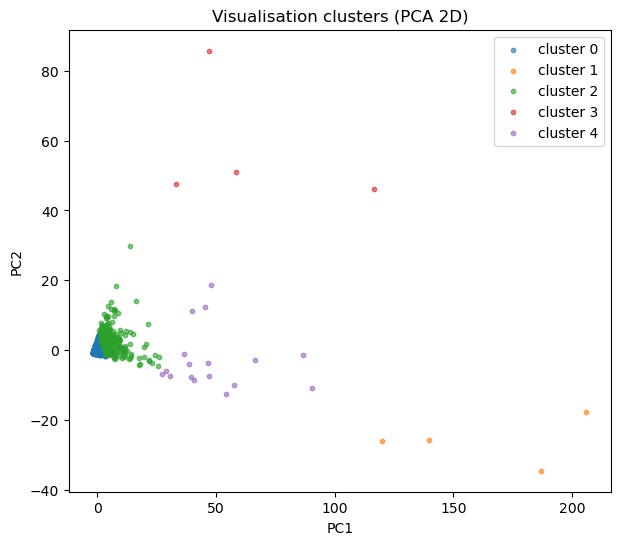

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(7,6))
for c in range(best_k):
    mask = labels == c
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=10, alpha=0.6, label=f'cluster {c}')
plt.legend()
plt.title('Visualisation clusters (PCA 2D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

# Conclusion